In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain-community tavily-python pandas groq langchain-groq langgraph -qU duckduckgo-search

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


In [ ]:
import re
import numpy as np
from sentence_transformers import SentenceTransformer
from langchain_core.tools import tool

# Load FAQ text from local storage
with open("/content/company_faq.txt", "r", encoding="utf-8") as file:
    faq_text = file.read()[1000]

# Split documents
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

# Initialize Hugging Face Embedding Model
hf_model = SentenceTransformer("all-MiniLM-L6-v2")


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: np.ndarray):
        self._arr = np.array(vectors)
        self._docs = docs

    @classmethod
    def from_docs(cls, docs):
        embeddings = hf_model.encode(
            [doc["page_content"] for doc in docs], convert_to_numpy=True
        )
        return cls(docs, embeddings)

    def query(self, query: str, k: int = 5) -> list[dict]:
        query_embedding = hf_model.encode([query], convert_to_numpy=True)[0]
        scores = query_embedding @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


# Create retriever with Hugging Face embeddings
retriever = VectorStoreRetriever.from_docs(docs)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any schedule changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


In [ ]:
import sqlite3
from datetime import datetime, date
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

DB_PATH = "/content/schedule.db"  # Ensure the correct database path
# Initialize database and table
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()
cursor.execute('''CREATE TABLE IF NOT EXISTS schedule
               (schedule_id INTEGER PRIMARY KEY AUTOINCREMENT,
                user_id TEXT NOT NULL,
                date TEXT NOT NULL,
                start_time TEXT NOT NULL,
                end_time TEXT NOT NULL,
                purpose TEXT NOT NULL)''')
conn.commit()
cursor.close()
conn.close()
@tool
def fetch_user_schedule(config: RunnableConfig) -> list[dict]:
    """Fetch all scheduled appointments for the user."""
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)
    if not user_id:
        raise ValueError("No user ID configured.")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    print(user_id)
    query = "SELECT * FROM schedule WHERE user_id = ?"
    cursor.execute(query, (user_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

@tool
def search_schedule(
    user_id: Optional[str] = None,
    start_time: Optional[str] = None,
    end_time: Optional[str] = None,
    date: Optional[str] = None,
    limit: int = 20,
) -> list[dict]:
    """
    Search scheduled appointments based on time and user ID.

    Description:
        Searches the schedule database for appointments that match the specified criteria.

    Args:
        user_id (Optional[str]): User ID to filter appointments. Defaults to None.
        start_time (Optional[str]): The minimum start time (in HH:MM format) to filter appointments. Defaults to None.
        end_time (Optional[str]): The maximum end time (in HH:MM format) to filter appointments. Defaults to None.
        date (Optional[str]): The date (in YYYY-MM-DD format) to filter appointments. Defaults to None.
        limit (int): The maximum number of results to return. Defaults to 20.

    Returns:
        list[dict]: A list of dictionaries representing the matching scheduled appointments.
    """
    print("""Search scheduled appointments based on time and user ID.""")
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    query = "SELECT * FROM schedule WHERE 1 = 1"
    params = []

    if user_id:
        query += " AND user_id = ?"
        params.append(user_id)

    if date:
        query += " AND date = ?"
        params.append(date)

    if start_time:
        query += " AND start_time >= ?"
        params.append(start_time)

    if end_time:
        query += " AND end_time <= ?"
        params.append(end_time)

    query += " LIMIT ?"
    params.append(limit)

    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    print(results)
    cursor.close()
    conn.close()

    return results

@tool
def update_schedule(
    schedule_id: int, new_start_time: str, new_end_time: str, new_date: str, new_purpose: str, *, config: RunnableConfig
) -> str:
    """
    Update an existing schedule entry.

    Description:
        Updates the appointment details for a specific schedule ID, provided that the schedule belongs to the configured user.

    Args:
        schedule_id (int): The ID of the schedule to update.
        new_start_time (str): New start time in HH:MM format.
        new_end_time (str): New end time in HH:MM format.
        new_date (str): New date in YYYY-MM-DD format.
        new_purpose (str): New purpose or description of the appointment.
        config (RunnableConfig): Configuration object containing user details.

    Returns:
        str: A message indicating whether the schedule was updated successfully or not.
    """
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)
    if not user_id:
        raise ValueError("No user ID configured.")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM schedule WHERE schedule_id = ? AND user_id = ?", (schedule_id, user_id))
    existing_schedule = cursor.fetchone()
    if not existing_schedule:
        cursor.close()
        conn.close()
        return "No matching schedule entry found for the user."

    cursor.execute(
        "UPDATE schedule SET start_time = ?, end_time = ?, date = ?, purpose = ? WHERE schedule_id = ?",
        (new_start_time, new_end_time, new_date, new_purpose, schedule_id),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Schedule successfully updated."
@tool
def add_schedule(
    date: str, start_time: str, end_time: str, purpose: str, *, config: RunnableConfig
) -> str:
    """
    Add a new scheduled appointment.

    Description:
        Inserts a new appointment into the schedule database if the specified time slot is available and valid.

    Args:
        date (str): The date for the appointment in YYYY-MM-DD format.
        start_time (str): The start time in HH:MM format.
        end_time (str): The end time in   :MM format.
        purpose (str): The purpose or description of the appointment.
        config (RunnableConfig): Configuration object containing user details.

    Returns:
        str: A confirmation message or an error message if the appointment could not be scheduled.
    """
    print(f"🔹 add_schedule called with: {date}, {start_time}, {end_time}, {purpose}")
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)
    if not user_id:
        raise ValueError("No user ID configured.")

    # Validate date format
    try:
        date_obj = datetime.strptime(date, "%Y-%m-%d").date()
        now = datetime.now().date()
        if date_obj < now:
            return "The date must be today or in the future."
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."

    # Validate time format
    try:
        start_time_obj = datetime.strptime(start_time, "%H:%M").time()
        end_time_obj = datetime.strptime(end_time, "%H:%M").time()
        if start_time_obj >= end_time_obj:
            return "Start time must be before end time."
    except ValueError:
        return "Invalid time format. Please use HH:MM."

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    # Insert the schedule into the database
    cursor.execute(
        "INSERT INTO schedule (user_id, date, start_time, end_time, purpose) VALUES (?, ?, ?, ?, ?)",
        (user_id, date, start_time, end_time, purpose),
    )
    if cursor.fetchone():
       return "❌ Time slot overlaps with existing appointment."
    conn.commit()

    cursor.close()
    conn.close()

    return f"✅ Appointment scheduled on {date} from {start_time} to {end_time} for {purpose} and ."


@tool
def cancel_schedule(schedule_id: int, *, config: RunnableConfig) -> str:
    """
    Cancel a scheduled appointment.

    Description:
        Cancels and removes a scheduled appointment from the database for the configured user.

    Args:
        schedule_id (int): The ID of the schedule to cancel.
        config (RunnableConfig): Configuration object containing user details.

    Returns:
        str: A message confirming the cancellation or indicating that no matching appointment was found.
    """
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id", None)
    if not user_id:
        raise ValueError("No user ID configured.")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM schedule WHERE schedule_id = ? AND user_id = ?", (schedule_id, user_id))
    existing_schedule = cursor.fetchone()
    if not existing_schedule:
        cursor.close()
        conn.close()
        return "No matching schedule entry found for the user."

    cursor.execute("DELETE FROM schedule WHERE schedule_id = ?", (schedule_id,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Schedule successfully cancelled."


In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_groq import ChatGroq
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
# from langchain_ollama import ChatOllama

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            user_id = configuration.get("user_id", None)
            state = {**state, "user_info": user_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# local_llm = "llama3.2:3b-instruct-fp16"
# llm = ChatOllama(model=local_llm, temperature=1)
local_llm = "llama3-8b-8192"
llm =ChatGroq(model=local_llm, temperature=0.5)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """Role: Intelligent Voice Support Agent for Goutam. Objective: Making Schedule appointments accurately using approved information.
               Strictly use the provided tools to handle appointment requests.

Core Guidelines:

1️⃣ Adaptive Greetings:
- For new conversations, use varied greetings as you want.
- For follow-ups, do NOT greet again.

2️⃣ Natural, Engaging Responses (No Repetitive Starters):
- Avoid generic openers like 'That's a great question.' Instead, start responses naturally.
- Example:
  - ✅ 'We use Swift and Xcode for iOS development.'
  - ✅ 'For iOS apps, we rely on Swift and Xcode to ensure high performance.'
  - ❌ Avoid: 'That's a great question. We use Swift and Xcode.'

3️⃣ Handling Unanswerable Questions (Rotate Refusals):
- If a question is outside approved data, do not guess. Use rotating polite refusals:
  - 'I currently only have access to pre-approved company resources.'
  - 'I'm unable to provide that information at this time.'
  - 'For privacy reasons, I cannot share that.'

4️⃣ Intelligent Responses Based on Query Type:
📌 Factual Queries:
  - ✅ 'We specialize in Swift and Xcode for iOS apps.'

📌 Unanswerable Queries:
  - ✅ 'I don’t have access to that information, but you can check our official website.'

📌 Feasibility Queries (e.g., timelines):
  - ✅ 'A one-month timeline is challenging. Our standard development time is 4-6 weeks for simple apps.'

📌 Appointment Scheduling:
  - ✅ Always check for existing bookings before confirming new slots.
    1. Ask for the purpose of their appointment.
    2. Request their preferred date and time for the appointment.
    3. Confirm all details with the caller, including the date and time of the appointment.

    "Remember that an appointment scheduling isn't completed until after the relevant tool has successfully been used."

📌 Goodbyes:
  - ✅ Rotate closing messages and end the conversation immediately.

- Keep all your responses short and simple. Use casual language, phrases like "Umm...", "Well...", and "I mean" are preferred.
- This is a voice conversation, so keep your responses short, like in a real conversation. Don't ramble for too long.

Complete or escalate the dialog to the host assistant. Do not waste the user’s time. Do not make up invalid tools or functions.

Current user:
<User>
{user_info}
</User>

Current time: {time}.
Current date: {date}.
""",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now(), date=date.today())


part_1_tools = [
    DuckDuckGoSearchRun(),
    fetch_user_schedule,
    add_schedule, cancel_schedule,update_schedule
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)


In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

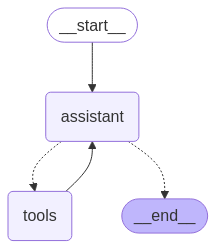

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant


# Update with the backup file so we can restart from the original place in each section

thread_id = str(uuid.uuid4())
user_id=input()
config = {
    "configurable": {

        "user_id": user_id,
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
while True:
    user_input=input()
    events = part_1_graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    if user_input =="bye":
      break


12
cancel the appointment
================================ Human Message =================================

cancel the appointment
================================== Ai Message ==================================
Tool Calls:
  cancel_schedule (call_r2sa)
 Call ID: call_r2sa
  Args:
    schedule_id: 12
================================= Tool Message =================================
Name: cancel_schedule

No matching schedule entry found for the user.
================================== Ai Message ==================================
Tool Calls:
  fetch_user_schedule (call_w2jn)
 Call ID: call_w2jn
  Args:
12
================================= Tool Message =================================
Name: fetch_user_schedule

[{"schedule_id": 6, "user_id": "12", "start_time": "What time works for you?", "end_time": "What time works for you?", "date": "What date would you like to schedule the appointment?", "purpose": "What is the purpose of the appointment?"}, {"schedule_id": 7, "user_id": "12", "start